<h1> Coursera Capstone Project </h1>

<h2> 1. Introduction/Business Problem </h2>

Located on the West Coast of the United States, Seattle is the largest city in the state of Washington and one of the fastest-growing cities since 2013. The reason for this lies in the fact that some of the biggest tech companies have established their business in this city. 

Seattle has 127 neighborhoods covering an area of 142.07 sq. mi (367.96 km2) where around 750,000 people live.  The population density is around 3151 persons per sq. km and the population growth is around 2.5% every year [1]. Despite the battle the city has concerning the population growth, for people who want to start a new business here, this might be an ideal place. 

Before starting a new business, a lot of things should be taken into account. When the idea exists, it requires further steps which include market research, business plan, financial plan, building a team, finding the location, and making it official [2]. The goal of this project is to examine what location would be the most convenient for somebody who wants to open an Italian restaurant in Seattle, Washington. In order for a business to thrive, the location of the restaurant should be in an area highly populated, where people circulate throughout the day to have lunch, grab a coffee, or have a meeting. Also, for this type of business, it would be ideal to be in an area where other restaurants are. However, it is also important not to be in an area overwhelmed by competitors [3]. Therefore, the following aspects should be considered before making the final conclusion: types of neighborhood, population in those neighborhoods, and number of competitors. 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import locale

import json # library to handle JSON files
import geojson

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import lxml
import re

from scipy.spatial.distance import cdist

import os

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium.map

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


<h2> 2. Data </h2>

In order to determine the most suitable location for a new Italian restaurant, the following data was necessary:
- For Seattle, WA neighborhood location data, I used the data provided by Zillow Inc. [4]. I read this data into a pandas dataframe to use for the following steps. 
- Once the neighborhood data was in a structured format, I used Foursquare location data to extract information about the most common venues, fit them into clusters, and determine the best perspective cluster using k-means clustering.
- For the population, I used data provided by the US Census Bureau from the 2010 census [5]. 

First, I need to create and populate a DataFrame. I have included a short code in the exception handling that is supposed to download the population data for each neighborhood, as I was unfortunately unable to find that from the official sources for all the neighborhoods. The population data is provided by the US Census Bureau from the 2010 census.

In [2]:
column_names = ['Neighborhood', 'Longitude', 'Latitude', 'Population', 'Coordinates']

df = pd.DataFrame(columns = column_names)
df

Empty DataFrame
Columns: [Neighborhood, Longitude, Latitude, Population, Coordinates]
Index: []

In [3]:
for filename in os.listdir(os.getcwd() + '/zillow_seattle_neighborhoods-master/geojson/'):
    with open (os.getcwd() + '/zillow_seattle_neighborhoods-master/geojson/'+ filename) as f:
        nbh = os.path.splitext(filename)[0].replace('_',' ').capitalize()
        temp = json.load(f)
        lon = 0
        lat = 0
        num = 0
        for t in temp['coordinates'][0][0]:
            lon = lon + t[0]
            lat = lat + t[1]
            num = num + 1
        lon = lon / num
        lat = lat / num
#         lon = temp['coordinates'][0][0][0][0]
#         lat = temp['coordinates'][0][0][0][1]
        coord = temp#['coordinates'][0][0]
        
        link = 'https://statisticalatlas.com/neighborhood/Washington/Seattle/' + nbh.replace(' ', '-') + '/Overview'
        try:
            page = requests.get(link)
            soup = BeautifulSoup(page.content, 'html5lib')
            tmp=soup.find_all(title='Population')
            locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
            population = locale.atoi(tmp[0].find_all('td')[0].text)

            df=df.append({'Neighborhood' : nbh, 'Longitude' : lon, 'Latitude' : lat, 'Population': population, 'Coordinates': coord}, ignore_index=True)

        except:
            print ("Can't find population data for neighborhood " + nbh)
            df=df.append({'Neighborhood' : nbh, 'Longitude' : lon, 'Latitude' : lat, 'Population': 0,  'Coordinates': coord}, ignore_index=True)

Can't find population data for neighborhood Green lake
Can't find population data for neighborhood Madison park
Can't find population data for neighborhood Highland park
Can't find population data for neighborhood South lake union
Can't find population data for neighborhood Portage bay
Can't find population data for neighborhood South park
Can't find population data for neighborhood Whittier heights
Can't find population data for neighborhood North delridge
Can't find population data for neighborhood Olympic hills
Can't find population data for neighborhood Victory heights
Can't find population data for neighborhood West seattle
Can't find population data for neighborhood University district
Can't find population data for neighborhood Mount baker
Can't find population data for neighborhood North beach
Can't find population data for neighborhood South delridge
Can't find population data for neighborhood Sand point
Can't find population data for neighborhood North college park
Can't find

In [176]:
#to see the first five rows
df.head()

Neighborhood   Longitude   Latitude Population  \
0     Green lake -122.338530  47.678202          0   
1   Madison park -122.285414  47.627222          0   
2    Meadowbrook -122.297094  47.707433       3318   
3         Bryant -122.285181  47.666595       5223   
4  Highland park -122.342096  47.530543          0   

                                         Coordinates  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  
1  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  
2  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  
3  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  
4  {'type': 'MultiPolygon', 'coordinates': [[[[-1...

Geopy library was used in order to grab latitude and longitude of Seatlle, WA. 

In [5]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent='st_explorer')
location=geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle, WA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle, WA are 47.6038321, -122.3300624.


Show on map everything I have so far in order to visualize neighborhoods:

In [6]:
# create map of Seattle using values from GeoJSON values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, coord in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Coordinates']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    
    folium.GeoJson(coord, name=label).add_child(label).add_to(map_seattle)
    
#     folium.CircleMarker(
#         [lat, lng],
#         radius=5,
#         popup=label,
#         color='blue',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_seattle) 
    
    
map_seattle

Now I need to grab data from Foursquare's API about the venues that are in the neighborhoods.

In [7]:
# @hidden_cell
CLIENT_ID = 'XPNPKHXQ4M0F3YMRRF2E3AWEK14T1U3K5FMB0A215ACHVJT1' # Foursquare ID
CLIENT_SECRET = 'VEAQE0UDA1M1UD2NPMDVSM5CXG2RO3CGBRW3RBUMJVUV22Y2' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [8]:
neighborhood_latitude = df.loc[26, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[26, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[26, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Madrona are 47.614694409945365, -122.28524026394706.


Grab the <b>top 100 venues</b> in <b>Madrona</b> within a radius of 500 meters:

In [9]:
search_query = ''
radius = 500
print(search_query + ' .... OK!')

LIMIT=100

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, search_query, radius, LIMIT)
url

 .... OK!


'https://api.foursquare.com/v2/venues/search?client_id=XPNPKHXQ4M0F3YMRRF2E3AWEK14T1U3K5FMB0A215ACHVJT1&client_secret=VEAQE0UDA1M1UD2NPMDVSM5CXG2RO3CGBRW3RBUMJVUV22Y2&ll=47.614694409945365,-122.28524026394706&v=20180605&query=&radius=500&limit=100'

In [10]:
results = requests.get(url).json()

To extract the categories of the venues I used get_category_type function:

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Here I structured data into pandas dataframe:

In [12]:
nearby_venues=results['response']['venues']
    
nearby_venues = json_normalize(nearby_venues) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name      categories        lat         lng
0  Madrona Briar Patch            Park  47.615523 -122.284377
1    Hidden Footbridge          Bridge  47.615070 -122.283158
2         Madrona Park           Beach  47.609881 -122.282789
3             HOLAHAUS            None  47.616040 -122.290228
4    goldmark overlook  Scenic Lookout  47.613189 -122.289080

To see how many venues were returned by Foursquare:

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


I repeated the process for all the neighborhoods in Seattle, WA nad created a new dataframe called seattle_venues:

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
seattle_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Green lake
Madison park
Meadowbrook
Bryant
Highland park
South lake union
Roxhill
Portage bay
Pinehurst
South park
Alki
Whittier heights
Broadmoor
Wallingford
Windermere
Laurelhurst
North delridge
Olympic hills
Victory heights
Wedgwood
West seattle
Eastlake
University district
Mount baker
North beach
South delridge
Madrona
Ballard
Broadview
Georgetown
Sand point
Admiral
North college park
Lower queen anne
Blue ridge
Hawthorne hills
Greenwood
Central district
Brighton
Interbay
Queen anne
Matthews beach
Pioneer square
Downtown
Capitol hill
Rainier beach
Fremont
Riverview
Leschi
Westlake
Industrial district
Madison valley
Seward park
Atlantic
View ridge
Maple leaf
Cedar park
Crown hill
Sunset hill
Phinney ridge
Belltown
Montlake
Olympic manor
Magnolia
Beacon hill
Denny-blaine
Roosevelt
Columbia city
Arbor heights
Northgate
Bitter lake
Ravenna
High point
Fauntleroy
Haller lake
First hill
Loyal heights
International district


Now I wanted to see the size of dataframe and the first five rows.

In [16]:
print(seattle_venues.shape)
seattle_venues.head()

(2343, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Green lake              47.678202              -122.33853   
1   Green lake              47.678202              -122.33853   
2   Green lake              47.678202              -122.33853   
3   Green lake              47.678202              -122.33853   
4   Green lake              47.678202              -122.33853   

             Venue  Venue Latitude  Venue Longitude        Venue Category  
0  Green Lake Loop       47.680666      -122.334540                 Trail  
1  Green Lake Park       47.680449      -122.332620                  Park  
2       El Naranjo       47.681672      -122.343992            Food Truck  
3           Bongos       47.676576      -122.347007  Caribbean Restaurant  
4      Beth's Café       47.682145      -122.344709                 Diner

Here I checked how many venues were returned for each neighborhood.

In [17]:
seattle_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                   
Admiral                                    48                      48     48   
Alki                                        9                       9      9   
Arbor heights                               3                       3      3   
Atlantic                                   32                      32     32   
Ballard                                   100                     100    100   
Beacon hill                                11                      11     11   
Belltown                                  100                     100    100   
Bitter lake                                50                      50     50   
Blue ridge                                  7                       7      7   
Brighton                                   16                      16     16   
Broadmoor                                  14                      14     14   
Broadview                                   2                       2      2   
Bryant                                     21                      21     21   
Capitol hill                               21                      21     21   
Cedar park                                  1                       1      1   
Central district                           32                      32     32   
Columbia city                              46                      46     46   
Crown hill                                 37                      37     37   
Denny-blaine                                6                       6      6   
Downtown                                  100                     100    100   
Eastlake                                   36                      36     36   
Fauntleroy                                 16                      16     16   
First hill                                 86                      86     86   
Fremont                                    38                      38     38   
Georgetown                                 39                      39     39   
Green lake                                 22                      22     22   
Greenwood                                  26                      26     26   
Haller lake                                 6                       6      6   
Hawthorne hills                             9                       9      9   
High point                                  6                       6      6   
Highland park                               6                       6      6   
Industrial district                        20                      20     20   
Interbay                                   22                      22     22   
International district                     66                      66     66   
Laurelhurst                                19                      19     19   
Leschi                                     23                      23     23   
Lower queen anne                           52                      52     52   
Loyal heights                              25                      25     25   
Madison park                               13                      13     13   
Madison valley                             30                      30     30   
Madrona                                    28                      28     28   
Magnolia                                   10                      10     10   
Maple leaf                                 30                      30     30   
Matthews beach                              3                       3      3   
Meadowbrook                                15                      15     15   
Montlake                                   17                      17     17   
Mount baker                                14                      14     14   
North beach                                12                      12     12   
North college park      

In [18]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 314 uniques categories.


Now, I'm analyzing each neighborhood:

In [19]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head()

Zoo Exhibit  ATM  Accessories Store  Adult Boutique  African Restaurant  \
0            0    0                  0               0                   0   
1            0    0                  0               0                   0   
2            0    0                  0               0                   0   
3            0    0                  0               0                   0   
4            0    0                  0               0                   0   

   Airport  American Restaurant  Amphitheater  Antique Shop  Aquarium  Arcade  \
0        0                    0             0             0         0       0   
1        0                    0             0             0         0       0   
2        0                    0             0             0         0       0   
3        0                    0             0             0         0       0   
4        0                    0             0             0         0       0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Assisted Living  Athletics & Sports  \
0                 0                0                   0   
1                 0                0                   0   
2                 0                0                   0   
3                 0                0                   0   
4                 0                0                   0   

   Australian Restaurant  Auto Garage  Auto Workshop  Automotive Shop  \
0                      0            0              0                0   
1                      0            0              0                0   
2                      0            0              0                0   
3                      0            0              0                0   
4                      0            0              0                0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Beach  Beer Bar  Beer Garden  \
0                 0                 0      0         0            0   
1                 0                 0      0         0            0   
2                 0                 0      0         0            0   
3                 0                 0      0         0            0   
4                 0                 0      0         0            0   

   Beer Store  Big Box Store  Bike Shop  Bistro  Board Shop  Boat Rental  \
0           0              0          0       0           0            0   
1           0              0          0       0           0            0   
2           0              0          0       0           0            0   
3           0              0          0       0           0            0   
4           0              0          0       0           0            0   

   Boat or Ferry  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0              0          0                 0         0              0   
1              0          0                 0         0              0   
2              0          0                 0         0              0   
3              0          0                 0         0              0   
4              0          0                 0         0              0   

   Boxing Gym  B

Examine the dataframe size.

In [20]:
seattle_onehot.shape

(2343, 314)

Next, I <b>grouped the rows by neighborhood</b> and by taking the mean of the frequency of occurence of each category:

In [21]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

Neighborhood  Zoo Exhibit       ATM  Accessories Store  \
0                  Admiral     0.000000  0.000000           0.000000   
1                     Alki     0.000000  0.000000           0.000000   
2            Arbor heights     0.000000  0.000000           0.000000   
3                 Atlantic     0.000000  0.000000           0.000000   
4                  Ballard     0.000000  0.000000           0.000000   
5              Beacon hill     0.000000  0.000000           0.000000   
6                 Belltown     0.000000  0.000000           0.000000   
7              Bitter lake     0.000000  0.020000           0.000000   
8               Blue ridge     0.000000  0.000000           0.000000   
9                 Brighton     0.000000  0.000000           0.000000   
10               Broadmoor     0.000000  0.000000           0.000000   
11               Broadview     0.000000  0.000000           0.000000   
12                  Bryant     0.000000  0.000000           0.000000   
13            Capitol hill     0.000000  0.000000           0.000000   
14              Cedar park     0.000000  0.000000           0.000000   
15        Central district     0.000000  0.000000           0.000000   
16           Columbia city     0.000000  0.000000           0.000000   
17              Crown hill     0.000000  0.000000           0.000000   
18            Denny-blaine     0.000000  0.000000           0.000000   
19                Downtown     0.000000  0.000000           0.000000   
20                Eastlake     0.000000  0.000000           0.000000   
21              Fauntleroy     0.000000  0.000000           0.000000   
22              First hill     0.000000  0.000000           0.000000   
23                 Fremont     0.000000  0.000000           0.000000   
24              Georgetown     0.000000  0.000000           0.000000   
25              Green lake     0.000000  0.000000           0.000000   
26               Greenwood     0.000000  0.000000           0.000000   
27             Haller lake     0.000000  0.000000           0.000000   
28         Hawthorne hills     0.000000  0.000000           0.000000   
29              High point     0.000000  0.000000           0.000000   
30           Highland park     0.000000  0.000000           0.000000   
31     Industrial district     0.000000  0.000000           0.000000   
32                Interbay     0.000000  0.000000           0.000000   
33  International district     0.000000  0.000000           0.000000   
34             Laurelhurst     0.000000  0.000000           0.000000   
35                  Leschi     0.000000  0.000000           0.000000   
36        Lower queen anne     0.000000  0.000000           0.000000   
37           Loyal heights     0.000000  0.000000           0.000000   
38            Madison park     0.000000  0.000000           0.000000   
39          Madison valley     0.000000  0.000000           0.000000   
40                 Madrona     0.000000  0.000000           0.000000   
41                Magnolia     0.000000  0.000000           0.000000   
42              Maple leaf     0.000000  0.000000           0.000000   
43          Matthews beach     0.000000  0.000000           0.000000   
44             Meadowbrook     0.000000  0.000000           0.000000   
45                Montlake     0.000000  0.000000           0.000000   
46             Mount baker     0.000000  0.000000           0.000000   
47             North beach     0.000000  0.000000           0.000000   
48      North college park     0.000000  0.000000           0.000000   
49          North delridge     0.000000  0.000000           0.000000   
50               Northgate     0.000000  0.000000           0.014706   
51           Olympic hills     0.000000  0.000000           0.000000   
52           Olympic manor     0.000000  0.000000           0.000000   
53           Phinney ridge     0.333333  0.000000           0.000000   
54               Pinehurst     0.000000  0.000000     

Here I wanted to see the new size of dataframe.

In [22]:
seattle_grouped.shape

(78, 314)

Then I wanted to see each neighborhood along with the top 5 most common venues.n venues.

In [23]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiral----
                 venue  freq
0          Coffee Shop  0.10
1                  Pub  0.06
2          Pizza Place  0.04
3  American Restaurant  0.04
4        Grocery Store  0.04


----Alki----
                  venue  freq
0                 Trail  0.11
1    Seafood Restaurant  0.11
2                  Park  0.11
3          Burger Joint  0.11
4  Other Great Outdoors  0.11


----Arbor heights----
             venue  freq
0            Beach  0.33
1             Park  0.33
2   Scenic Lookout  0.33
3  Other Nightlife  0.00
4      Pet Service  0.00


----Atlantic----
         venue  freq
0         Park  0.09
1  Bus Station  0.06
2  Coffee Shop  0.06
3       Museum  0.03
4        Trail  0.03


----Ballard----
                     venue  freq
0                  Brewery  0.10
1              Coffee Shop  0.06
2                      Bar  0.06
3           Sandwich Place  0.04
4  New American Restaurant  0.04


----Beacon hill----
           venue  freq
0    Gas Station  0.09
1    Coffee 

                venue  freq
0     Harbor / Marina  0.09
1         Coffee Shop  0.09
2  Seafood Restaurant  0.09
3       Boat or Ferry  0.04
4   Outdoor Sculpture  0.04


----University district----
                   venue  freq
0            Coffee Shop  0.06
1  Vietnamese Restaurant  0.04
2            Pizza Place  0.03
3        Bubble Tea Shop  0.03
4         Cosmetics Shop  0.03


----Victory heights----
                  venue  freq
0  Marijuana Dispensary  0.14
1           Gas Station  0.07
2      Asian Restaurant  0.07
3           Music Store  0.07
4                  Park  0.07


----View ridge----
                     venue  freq
0  New American Restaurant  0.17
1                      Gym  0.17
2             Tennis Court  0.17
3          Harbor / Marina  0.17
4                     Pool  0.17


----Wallingford----
              venue  freq
0       Coffee Shop  0.07
1               Bar  0.06
2  Asian Restaurant  0.06
3       Pizza Place  0.06
4   Thai Restaurant  0.06


----Wedgwoo

Then I put that into a pandas dataframe. I wrote a function to sort venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

And top 10 most common venues, put together into a new dataframe:

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        Admiral           Coffee Shop                   Pub   
1           Alki                 Trail                 Beach   
2  Arbor heights        Scenic Lookout                  Park   
3       Atlantic                  Park           Bus Station   
4        Ballard               Brewery                   Bar   

  3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place            Grocery Store   American Restaurant   
1                  Park       Seafood Restaurant  Other Great Outdoors   
2                 Beach                    Field           Event Space   
3           Coffee Shop        Convenience Store                Garden   
4           Coffee Shop  New American Restaurant        Sandwich Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Salon / Barbershop             Gift Shop       Thai Restaurant   
1          Burger Joint      Greek Restaurant      Volleyball Court   
2            Eye Doctor           Fabric Shop    Falafel Restaurant   
3                Museum        Scenic Lookout                Bakery   
4            Food Truck          Burger Joint    Mexican Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0                  Bank                    Bar  
1           Post Office   Fast Food Restaurant  
2        Farmers Market   Fast Food Restaurant  
3  Ethiopian Restaurant                   Café  
4        Clothing Store       Sushi Restaurant

My data is ready now for cluster analysis.

<h2> 4. Results </h2>

In order to choose the number of clusters, I performed The Elbow Method for optimal k. This method showed that the optimal k should be 7 or 8. However, after examining each of them, I decided to do 3 clusters given that after analyzing venues in each cluster, it made much more sense :

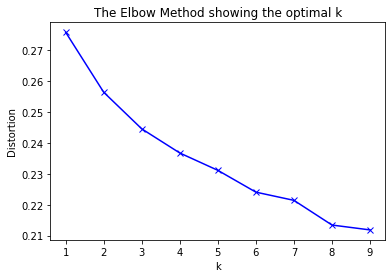

In [26]:
seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(seattle_grouped_clustering)
    kmeanModel.fit(seattle_grouped_clustering)
    distortions.append(sum(np.min(cdist(seattle_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / seattle_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [61]:
# setting number of clusters
kclusters = 3

# running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [62]:
seattle_grouped_clustering.head()

Zoo Exhibit  ATM  Accessories Store  Adult Boutique  African Restaurant  \
0          0.0  0.0                0.0             0.0                 0.0   
1          0.0  0.0                0.0             0.0                 0.0   
2          0.0  0.0                0.0             0.0                 0.0   
3          0.0  0.0                0.0             0.0                 0.0   
4          0.0  0.0                0.0             0.0                 0.0   

   Airport  American Restaurant  Amphitheater  Antique Shop  Aquarium  Arcade  \
0      0.0             0.041667           0.0           0.0       0.0     0.0   
1      0.0             0.000000           0.0           0.0       0.0     0.0   
2      0.0             0.000000           0.0           0.0       0.0     0.0   
3      0.0             0.000000           0.0           0.0       0.0     0.0   
4      0.0             0.010000           0.0           0.0       0.0     0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0     0.020833         0.0             0.020833   
1                     0.0     0.000000         0.0             0.000000   
2                     0.0     0.000000         0.0             0.000000   
3                     0.0     0.000000         0.0             0.000000   
4                     0.0     0.000000         0.0             0.000000   

   Asian Restaurant  Assisted Living  Athletics & Sports  \
0               0.0              0.0                 0.0   
1               0.0              0.0                 0.0   
2               0.0              0.0                 0.0   
3               0.0              0.0                 0.0   
4               0.0              0.0                 0.0   

   Australian Restaurant  Auto Garage  Auto Workshop  Automotive Shop  \
0               0.020833          0.0            0.0             0.00   
1               0.000000          0.0            0.0             0.00   
2               0.000000          0.0            0.0             0.00   
3               0.000000          0.0            0.0             0.00   
4               0.000000          0.0            0.0             0.01   

   BBQ Joint  Baby Store  Bagel Shop   Bakery      Bank       Bar  \
0       0.00         0.0         0.0  0.00000  0.020833  0.020833   
1       0.00         0.0         0.0  0.00000  0.000000  0.000000   
2       0.00         0.0         0.0  0.00000  0.000000  0.000000   
3       0.00         0.0         0.0  0.03125  0.000000  0.000000   
4       0.01         0.0         0.0  0.00000  0.010000  0.060000   

   Baseball Field  Baseball Stadium  Basketball Court     Beach  Beer Bar  \
0             0.0               0.0               0.0  0.000000      0.00   
1             0.0               0.0               0.0  0.111111      0.00   
2             0.0               0.0               0.0  0.333333      0.00   
3             0.0               0.0               0.0  0.000000      0.00   
4             0.0               0.0               0.0  0.000000      0.01   

   Beer Garden  Beer Store  Big Box Store  Bike Shop  Bistro  Board Shop  \
0          0.0         0.0            0.0        0.0     0.0         0.0   
1          0.0         0.0            0.0        0.0     0.0         0.0   
2          0.0         0.0            0.0        0.0     0.0         0.0   
3          0.0         0.0            0.0        0.0     0.0         0.0   
4          0.0         0.0            0.0        0.0     0.0         0.0   

   Boat Rental  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0          0.0            0.0   0.020833               0.0      0.00   
1          0.0            0.0   0.000000               0.0      0.00   
2          0.0            0.0   0.000000               0.0      0.00   
3          0.0            0.0   0.000000               0.0      0.00   
4          0.0            0.0   0.000000               0.0      0.01   

   Bowling Alley  Boxing Gym

Here I created a new dataframe that includes the cluster as well as the <b>top 10 venues for each neighborhood</b>

In [64]:
# adding clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = df

# merging inside_the_beltline_grouped with inside_the_beltline to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged # checking the last columns!

Neighborhood   Longitude   Latitude Population  \
0               Green lake -122.338530  47.678202          0   
1             Madison park -122.285414  47.627222          0   
2              Meadowbrook -122.297094  47.707433       3318   
3                   Bryant -122.285181  47.666595       5223   
4            Highland park -122.342096  47.530543          0   
5         South lake union -122.337092  47.622768          0   
6                  Roxhill -122.368572  47.528958       4250   
7              Portage bay -122.315729  47.642522          0   
8                Pinehurst -122.319948  47.722909       5294   
9               South park -122.326483  47.529429          0   
10                    Alki -122.398490  47.584075       7442   
11        Whittier heights -122.370599  47.682236          0   
12               Broadmoor -122.295780  47.635205        738   
13             Wallingford -122.334213  47.660058      15826   
14              Windermere -122.263168  47.671518       2673   
15             Laurelhurst -122.282221  47.660229       4880   
16          North delridge -122.369070  47.566700          0   
17           Olympic hills -122.299686  47.725445          0   
18         Victory heights -122.305042  47.709511          0   
19                Wedgwood -122.302244  47.690681       7793   
20            West seattle -122.392759  47.554721          0   
21                Eastlake -122.328373  47.634406       4202   
22     University district -122.305813  47.660393          0   
23             Mount baker -122.286330  47.575619          0   
24             North beach -122.399032  47.696121          0   
25          South delridge -122.360373  47.531138          0   
26                 Madrona -122.285240  47.614694       3616   
27                 Ballard -122.375920  47.663892      10121   
28               Broadview -122.366563  47.715431       8192   
29              Georgetown -122.317761  47.542934       1277   
30              Sand point -122.260511  47.684479          0   
31                 Admiral -122.386309  47.579560      11202   
32      North college park -122.333175  47.700465          0   
33        Lower queen anne -122.360477  47.625938          0   
34              Blue ridge -122.373340  47.704363          0   
35         Hawthorne hills -122.274082  47.672948          0   
36               Greenwood -122.358812  47.699953      15271   
37        Central district -122.307653  47.604984          0   
38                Brighton -122.273332  47.538450       7496   
39                Interbay -122.383944  47.641412       1686   
40              Queen anne -122.362412  47.640997          0   
41          Matthews beach -122.278920  47.705506          0   
42          Pioneer square -122.334585  47.598524          0   
43                Downtown -122.341445  47.607474       7990   
44            Capitol hill -122.308487  47.631613          0   
45           Rainier beach -122.263341  47.517680          0   
46                 Fremont -122.356275  47.659270      11734   
47               Riverview -122.353374  47.543331       4113   
48                  Leschi -122.291626  47.600635       5453   
49                Westlake -122.342230  47.634111       3295   
50     Industrial district -122.359915  47.568170          0   
51          Madison valley -122.294205  47.622929          0   
52             Seward park -122.265029  47.548262          0   
53                Atlantic -122.298152  47.589490       1003   
54              View ridge -122.272949  47.685776          0   
55              Maple leaf -122.318164  47.692017          0   
56              Cedar park -122.282406  47.720606          0   
57              Crown hill -122.370336  47.694992          0   
58             Sunset hill -122.401076  47.676832          0   
59           Phinney ridge -122.347951  47.672481          0   
60                Belltown -122.349934  47.614361      11067   
61                Montlake -122.301030  47.637

Visualizing clusters:

In [65]:
# creating map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, coord in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Choropleth(coord, name=label, fill_color=rainbow[cluster-2], fill_opacity=0.2).add_child(label).add_to(map_clusters)
       
map_clusters


Exmine every cluster:

In [66]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

Longitude  Cluster Labels 1st Most Common Venue  2nd Most Common Venue  \
0  -122.338530               0                  Park                    Pub   
7  -122.315729               0            Playground                   Park   
8  -122.319948               0                  Park            Pizza Place   
9  -122.326483               0                  Park                Brewery   
10 -122.398490               0                 Trail                  Beach   
14 -122.263168               0      Greek Restaurant                   Park   
15 -122.282221               0                  Park               Pharmacy   
23 -122.286330               0                  Park  Vietnamese Restaurant   
24 -122.399032               0                 Beach                  Trail   
26 -122.285240               0                  Park              Gift Shop   
44 -122.308487               0                  Park                 Garden   
47 -122.353374               0                 Trail                   Park   
50 -122.359915               0                  Park                    Gym   
52 -122.265029               0                  Park                  Trail   
65 -122.284742               0                  Park     Country Dance Club   
68 -122.382279               0        Scenic Lookout                   Park   
72 -122.364297               0            Food Truck      Convenience Store   
73 -122.389216               0         Boat or Ferry                   Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Beach       Motorcycle Shop                 Diner   
7          Moving Target           Pizza Place                   Spa   
8            Golf Course          Liquor Store      Basketball Court   
9         Rental Service               Library        Shipping Store   
10                  Park    Seafood Restaurant  Other Great Outdoors   
14           Snack Place       Harbor / Marina           Pizza Place   
15            Steakhouse          Burger Joint                  Café   
23             BBQ Joint         Grocery Store                  Bank   
24    Mexican Restaurant    Athletics & Sports               Dog Run   
26           Coffee Shop                 Beach                   Spa   
44        Scenic Lookout      Sculpture Garden            Art Museum   
47                Bakery              Bus Line        Baseball Field   
50           Coffee Shop            Food Truck        Sandwich Place   
52       Nature Preserve            Playground                   Zoo   
65   Monument / Landmark                 Beach                 Field   
68                 Beach                 Field           Event Space   
72        Hardware Store                  Park           Gas Station   
73            Playground        Pilates Studio      Botanical Garden   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Gas Station           Bus Station          Tennis Court   
7   Ethiopian Restaurant                   Bar        Massage Studio   
8             Smoke Shop                 Trail      Business Service   
9         Farmers Market  Ethiopian Restaurant           Event Space   
10          Burger Joint      Greek Restaurant      Volleyball Court   
14                 Beach           Bus Station    Falafel Restaurant   
15       Thai Restaurant                   Gym              Bus Stop   
23            Food Truck       Harbor / Marina      Asian Restaurant   
24            Playground      Kebab Restaurant                 Plaza   
26     French Restaurant   Monument / Landmark  Ethiopian Restaurant   
44            Food Truck              Bus Stop     Outdoor Sculpture   
47                   Zoo            Eye Doctor           Fabric Shop   
50                   Bar           Music Venue                 Trail   
52        Farmers Market  Ethiopian Restaurant           Event Space   
65           Event Space            Eye Doctor        

In [67]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
28 -122.366563               1                 Trail                  Park   
41 -122.278920               1                 Trail                  Tree   
56 -122.282406               1                 Trail    Frozen Yogurt Shop   

          3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
28          Fried Chicken Joint     Electronics Store  Ethiopian Restaurant   
41  Eastern European Restaurant     Electronics Store  Ethiopian Restaurant   
56            Electronics Store  Ethiopian Restaurant           Event Space   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
28           Event Space            Eye Doctor           Fabric Shop   
41           Event Space            Eye Doctor           Fabric Shop   
56            Eye Doctor           Fabric Shop    Falafel Restaurant   

   9th Most Common Venue 10th Most Common Venue  
28    Falafel Restaurant         Farmers Market  
41    Falafel Restaurant         Farmers Market  
56        Farmers Market   Fast Food Restaurant

In [102]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

Longitude  Cluster Labels  1st Most Common Venue  \
1  -122.285414               2                   Café   
2  -122.297094               2            Pizza Place   
3  -122.285181               2               Pharmacy   
4  -122.342096               2                    Gym   
5  -122.337092               2            Coffee Shop   
6  -122.368572               2           Soccer Field   
11 -122.370599               2                    Bar   
12 -122.295780               2                 Garden   
13 -122.334213               2            Coffee Shop   
16 -122.369070               2            Coffee Shop   
17 -122.299686               2         Farmers Market   
18 -122.305042               2   Marijuana Dispensary   
19 -122.302244               2      Convenience Store   
20 -122.392759               2            Coffee Shop   
21 -122.328373               2        Harbor / Marina   
22 -122.305813               2            Coffee Shop   
25 -122.360373               2      Convenience Store   
27 -122.375920               2                Brewery   
29 -122.317761               2         Sandwich Place   
30 -122.260511               2           Soccer Field   
31 -122.386309               2            Coffee Shop   
32 -122.333175               2                   Park   
33 -122.360477               2               Bus Stop   
34 -122.373340               2       Toy / Game Store   
35 -122.274082               2    American Restaurant   
36 -122.358812               2            Pizza Place   
37 -122.307653               2            Coffee Shop   
38 -122.273332               2     Mexican Restaurant   
39 -122.383944               2               Bus Stop   
40 -122.362412               2        Thai Restaurant   
42 -122.334585               2            Coffee Shop   
43 -122.341445               2            Coffee Shop   
45 -122.263341               2                   Café   
46 -122.356275               2                   Park   
48 -122.291626               2            Coffee Shop   
49 -122.342230               2        Harbor / Marina   
51 -122.294205               2      French Restaurant   
53 -122.298152               2                   Park   
54 -122.272949               2           Tennis Court   
55 -122.318164               2            Coffee Shop   
57 -122.370336               2             Food Truck   
58 -122.401076               2        Harbor / Marina   
59 -122.347951               2            Zoo Exhibit   
60 -122.349934               2                    Bar   
61 -122.301030               2               Bus Stop   
62 -122.381659               2            Coffee Shop   
63 -122.404725               2                  Trail   
64 -122.303014               2            Supermarket   
66 -122.314532               2            Coffee Shop   
67 -122.285660               2            Pizza Place   
69 -122.325196               2         Sandwich Place   
70 -122.349220               2   Fast Food Restaurant   
71 -122.302787               2            Pizza Place   
74 -122.330809               2            Coffee Shop   
75 -122.325501               2            Coffee Shop   
76 -122.385270               2                   Park   
77 -122.317982               2  Vietnamese Restaurant   

            2nd Most Common Venue      3rd Most Common Venue  \
1                        Ski Area                     Bakery   
2            Marijuana Dispensary                  Pet Store   
3             American Restaurant                Coffee Shop   
4                     Gas Station               Home Service   
5                      Food Truck                      Hotel   
6                      Playground     Furniture / Home Store   
11                           Park                  Pet Store   
12               Botanical Garden                       Park   
13               Asian Restaurant                Pizza Place   
16                       Bus Line                Bus Stati

For easier tracking I added folium icons that represent each cluster (parks and scenic lookout, outdoor activities, and business/residential area) on top of each neighborhood.

In [89]:
map_icons = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, coord in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Choropleth(coord, name=label, fill_color=rainbow[cluster-2], fill_opacity=0.2).add_child(label).add_to(map_icons)

        
for lat, lon, poi, cluster, coord in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    icons = {0: ['green','tree'], 1: ['orange', 'bicycle'], 2: ['purple', 'coffee']} 
    folium.Marker(
        [lat, lon],
        popup=label,
        icon=folium.Icon(color=icons[cluster][0], icon=icons[cluster][1], prefix='fa')).add_to(map_icons)  
        
map_icons




And a map that shows the population. Unfortunately, some neighborhoods do not have the population data available.

In [185]:
#creating map
map_heatmap = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(np.amax(seattle_merged['Population']))
ys = [i + x + (i*x)**2 for i in range(np.amax(seattle_merged['Population']))]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# colormap = plt.get_cmap('YlOrRd')
colors_array = cm.YlOrRd(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

markers_colors = []
for lat, lon, poi, cluster, coord, population in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates'], seattle_merged['Population']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Choropleth(coord,
                      name=label, 
                      fill_color=rainbow[population-1], 
                      fill_opacity=0.4).add_child(label).add_to(map_heatmap)
       
map_heatmap

Now some reformating is needed in order to extract all the venues that are restaurants in cluster 2. The way this is done is by creating a copy of the dataframe, then deleting every row that does <b>not</b> contain the word 'restaurant' in the 'Venue Category' column.

In [187]:
column_names_venues = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
seattle_venues_clustered = pd.DataFrame(columns = column_names_venues)
seattle_venues_clustered
for neighborhood in seattle_merged.loc[seattle_merged['Cluster Labels'] == 2]['Neighborhood']:
    seattle_venues_clustered=seattle_venues_clustered.append(seattle_venues.loc[seattle_venues['Neighborhood']==neighborhood], ignore_index=True)
restaurants = seattle_venues_clustered.copy()
seattle_venues_clustered

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0               Madison park              47.627222             -122.285414   
1               Madison park              47.627222             -122.285414   
2               Madison park              47.627222             -122.285414   
3               Madison park              47.627222             -122.285414   
4               Madison park              47.627222             -122.285414   
5               Madison park              47.627222             -122.285414   
6               Madison park              47.627222             -122.285414   
7               Madison park              47.627222             -122.285414   
8               Madison park              47.627222             -122.285414   
9               Madison park              47.627222             -122.285414   
10              Madison park              47.627222             -122.285414   
11              Madison park              47.627222             -122.285414   
12              Madison park              47.627222             -122.285414   
13               Meadowbrook              47.707433             -122.297094   
14               Meadowbrook              47.707433             -122.297094   
15               Meadowbrook              47.707433             -122.297094   
16               Meadowbrook              47.707433             -122.297094   
17               Meadowbrook              47.707433             -122.297094   
18               Meadowbrook              47.707433             -122.297094   
19               Meadowbrook              47.707433             -122.297094   
20               Meadowbrook              47.707433             -122.297094   
21               Meadowbrook              47.707433             -122.297094   
22               Meadowbrook              47.707433             -122.297094   
23               Meadowbrook              47.707433             -122.297094   
24               Meadowbrook              47.707433             -122.297094   
25               Meadowbrook              47.707433             -122.297094   
26               Meadowbrook              47.707433             -122.297094   
27               Meadowbrook              47.707433             -122.297094   
28                    Bryant              47.666595             -122.285181   
29                    Bryant              47.666595             -122.285181   
30                    Bryant              47.666595             -122.285181   
31                    Bryant              47.666595             -122.285181   
32                    Bryant              47.666595             -122.285181   
33                    Bryant              47.666595             -122.285181   
34                    Bryant              47.666595             -122.285181   
35                    Bryant              47.666595             -122.285181   
36                    Bryant              47.666595             -122.285181   
37                    Bryant              47.666595             -122.285181   
38                    Bryant              47.666595             -122.285181   
39                    Bryant              47.666595             -122.285181   
40                    Bryant              47.666595             -122.285181   
41                    Bryant              47.666595             -122.285181   
42                    Bryant              47.666595             -122.285181   
43                    Bryant              47.666595             -122.285181   
44                    Bryant              47.666595             -122.285181   
45                    Bryant              47.666595             -122.285181   
46                    Bryant              47.666595             -122.285181   
47                    Bryant              47.666595             -122.285181   
48                    Bryant              47.666595             -122.285181   
49             Highland park              47.530543             -1

In [188]:
for ind, row in seattle_venues_clustered.iterrows():
#     print(row['Venue Category'])
    if 'Restaurant' not in row['Venue Category']:
        restaurants = restaurants.drop(index=ind)
restaurants


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0               Madison park              47.627222             -122.285414   
20               Meadowbrook              47.707433             -122.297094   
30                    Bryant              47.666595             -122.285181   
32                    Bryant              47.666595             -122.285181   
36                    Bryant              47.666595             -122.285181   
38                    Bryant              47.666595             -122.285181   
40                    Bryant              47.666595             -122.285181   
47                    Bryant              47.666595             -122.285181   
59          South lake union              47.622768             -122.337092   
65          South lake union              47.622768             -122.337092   
68          South lake union              47.622768             -122.337092   
72          South lake union              47.622768             -122.337092   
73          South lake union              47.622768             -122.337092   
78          South lake union              47.622768             -122.337092   
88          South lake union              47.622768             -122.337092   
92          South lake union              47.622768             -122.337092   
95          South lake union              47.622768             -122.337092   
101         South lake union              47.622768             -122.337092   
120         South lake union              47.622768             -122.337092   
133         South lake union              47.622768             -122.337092   
136         South lake union              47.622768             -122.337092   
138         South lake union              47.622768             -122.337092   
144         South lake union              47.622768             -122.337092   
147         South lake union              47.622768             -122.337092   
149         South lake union              47.622768             -122.337092   
168         Whittier heights              47.682236             -122.370599   
174         Whittier heights              47.682236             -122.370599   
177         Whittier heights              47.682236             -122.370599   
204                Broadmoor              47.635205             -122.295780   
214              Wallingford              47.660058             -122.334213   
222              Wallingford              47.660058             -122.334213   
224              Wallingford              47.660058             -122.334213   
228              Wallingford              47.660058             -122.334213   
231              Wallingford              47.660058             -122.334213   
235              Wallingford              47.660058             -122.334213   
236              Wallingford              47.660058             -122.334213   
239              Wallingford              47.660058             -122.334213   
240              Wallingford              47.660058             -122.334213   
243              Wallingford              47.660058             -122.334213   
246              Wallingford              47.660058             -122.334213   
253              Wallingford              47.660058             -122.334213   
256              Wallingford              47.660058             -122.334213   
266              Wallingford              47.660058             -122.334213   
267              Wallingford              47.660058             -122.334213   
268              Wallingford              47.660058             -122.334213   
272              Wallingford              47.660058             -122.334213   
273              Wallingford              47.660058             -122.334213   
274              Wallingford              47.660058             -122.334213   
276              Wallingford              47.660058             -122.334213   
285           North delridge              47.566700             -1

In [144]:
final_restaurants={}
for neighborhood in restaurants['Neighborhood'].unique():
    final_restaurants[neighborhood]=restaurants.loc[restaurants['Neighborhood']==neighborhood].count()[0]
restaurants_df = pd.DataFrame(final_restaurants, index=[0])
restaurants_df_transposed=restaurants_df.transpose()
restaurants_df_transposed=restaurants_df_transposed.sort_values(by=[0])

Visualization of frequency of restaurants in all neighborhoods of business/residential area.

In [177]:
import plotly.graph_objects as go
fig = go.Figure(go.Bar(
            y=restaurants_df_transposed.index,
            x=restaurants_df_transposed[0],
            orientation='h'))
fig.update_layout(autosize=False, width = 1000, height = 1000)
fig.show()

Visualization of the most convenient neighborhoods in Seattle, WA for opening an Italian restaurant.

In [175]:
map_italian_restaurant = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, coord in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates']):
    if poi == 'Wallingford' or poi =='South lake union' or poi =='Ballard' or poi =='Roosevelt' or poi =='Ravenna' or poi =='Columbia city' or poi =='Bitter lake':
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.Choropleth(coord, name=label, fill_color=rainbow[cluster-2], fill_opacity=0.2).add_child(label).add_to(map_italian_restaurant)

        
for lat, lon, poi, cluster, coord in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels'].astype(int), seattle_merged['Coordinates']):
    if poi == 'Wallingford' or poi =='South lake union' or poi =='Ballard' or poi =='Roosevelt' or poi =='Ravenna' or poi =='Columbia city' or poi =='Bitter lake':
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        icons = {0: ['green','tree'], 1: ['orange', 'bicycle'], 2: ['purple', 'cutlery']} 
        folium.Marker(
            [lat, lon],
            popup=label,
            icon=folium.Icon(color=icons[cluster][0], icon=icons[cluster][1], prefix='fa')).add_to(map_italian_restaurant)  
        
map_italian_restaurant

<h2>5. Discussion</h2>

After obtaining necessary data and structuring it in a proper dataframe, the k-means cluster analysis showed that all neighborhoods in Seattle, WA could be grouped into three separate categories: parks and scenic lookout, outdoor activities, and business/residential area. Given the goal of this project, the conclusion was that neighborhoods that belong to business/residential area would be the most suitable for further analyses. 

The next analysis showed that highly populated areas were mostly the ones that belong to business/residential areas. The final analysis showed the frequency of restaurants in each neighborhood of business/residential area and it was the final piece in determing which neighborhoods would be the most convenient for opening an Italian restaurant.  

<h2>6. Conclusion</h2>

Even though starting a new business requires a lot of steps and considerations before it becomes official, one of the most important things that should be carefully explored is its location. For this project, the goal was to examine the most convenient location for opening an Italian restaurant in Seattle, Washington. The goal was to determine the location based on the type of neighborhood, number of people who live in that neighborhood, and number of competitors. 

After all analyses were performed, the conclusion is that the most convenient neighborhoods that belong to business/residential area, highly populated, with an optimal number of competitors would be Wallingford, Salt Lake Union, Ballard, Roosevelt, Ravenna, Columbia City, and Bitter Lake. 

Although this project narrowed the most suitable neighborhoods for opening an Italian restaurant, in future projects it should be explored even further. Depending on the target customers, in the next project it would be convenient to use other data such as the structure of population in a specific neighborhood, business revenues in that area (if available), or public parking areas. 

<h2> References </h2>

[1]	Population Of Seattle | Seattle Population 2019. (December, 30, 2018). Retrieved from https://theuspopulation.com/seattle-population/

[2]	McCreary, Matthew. (n.d.) The Complete, 12-Step Guide to Starting a Business. Retrieved from https://www.entrepreneur.com/article/297899 

[3]	Why the Location of Your Restaurant is So Important. (n.d.). Retrieved from https://www.tigerchef.com/why-the-location-of-your-business-is.html

[4]	Zillow Neighborhood Maps of Seattle in GeoJSON and KML Formats. (December, 2 2013). Retrieved from https://github.com/craic/zillow_seattle_neighborhoods

[5]	Overview of Seattle, Washington - Population. (n.d.). Retrieved from https://statisticalatlas.com/place/Washington/Seattle/Overview